# 11.3 Two approaches for representing groups of words: Sets and sequences

How a machine learning model should represent individual words is a relatively uncontroversial question: they’re categorical features (values from a predefined set), and we
know how to handle those. They should be encoded as dimensions in a feature space,
or as category vectors (word vectors in this case). A much more problematic question,
however, is how to encode *the way words are woven into sentences*: word order.

The problem of order in natural language is an interesting one: unlike the steps of
a timeseries, words in a sentence don’t have a natural, canonical order. Different languages order similar words in very different ways. For instance, the sentence structure
of English is quite different from that of Japanese. Even within a given language, you
can typically say the same thing in different ways by reshuffling the words a bit. Even
further, if you fully randomize the words in a short sentence, you can still largely figure out what it was saying—though in many cases significant ambiguity seems to arise.
Order is clearly important, but its relationship to meaning isn’t straightforward.

 How to represent word order is the pivotal question from which different kinds of
NLP architectures spring. The simplest thing you could do is just discard order and
treat text as an unordered set of words—this gives you *bag-of-words models*. You could
also decide that words should be processed strictly in the order in which they appear,
one at a time, like steps in a timeseries—you could then leverage the recurrent models
from the last chapter. Finally, a hybrid approach is also possible: the Transformer architecture is technically order-agnostic, yet it injects word-position information into
the representations it processes, which enables it to simultaneously look at different
parts of a sentence (unlike RNNs) while still being order-aware. Because they take into
account word order, both RNNs and Transformers are called *sequence models*.

Historically, most early applications of machine learning to NLP just involved
bag-of-words models. Interest in sequence models only started rising in 2015, with the
rebirth of recurrent neural networks. Today, both approaches remain relevant. Let’s
see how they work, and when to leverage which.

We’ll demonstrate each approach on a well-known text classification benchmark:
the IMDB movie review sentiment-classification dataset. In chapters 4 and 5, you
worked with a prevectorized version of the IMDB dataset; now, let’s process the raw
IMDB text data, just like you would do when approaching a new text-classification
problem in the real world.

## 11.3.1 Preparing the IMDB movie reviews data

Let’s start by downloading the dataset from the Stanford page of Andrew Maas and
uncompressing it:

In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

!rm -r aclImdb/train/unsup

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  17.8M      0  0:00:04  0:00:04 --:--:-- 17.8M


You’re left with a directory named aclImdb. The train/pos/ directory contains a set of 12,500 text files, each of which
contains the text body of a positive-sentiment movie review to be used as training data.
The negative-sentiment reviews live in the “neg” directories. In total, there are 25,000
text files for training and another 25,000 for testing.

Take a look at the content of a few of these text files. Whether you’re working with
text data or image data, remember to always inspect what your data looks like before
you dive into modeling it. It will ground your intuition about what your model is actually doing:

In [3]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

Next, let’s prepare a validation set by setting apart 20% of the training text files in a
new directory, aclImdb/val:

In [4]:
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    # Shuffle the list of training files using a seed, to ensure we get the same validation set every time we run the code.
    random.Random(1337).shuffle(files)
    # Take 20% of the training files to use for validation.
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    # Move the files to aclImdb/val/neg and aclImdb/val/pos.
    for fname in val_files:
        shutil.move(train_dir / category / fname, val_dir / category / fname)

Remember how, in chapter 8, we used the `image_dataset_from_directory` utility to
create a batched `Dataset` of images and their labels for a directory structure? You can
do the exact same thing for text files using the `text_dataset_from_directory` utility.
Let’s create three Dataset objects for training, validation, and testing:

In [6]:
from tensorflow import keras

Running `train_ds = ...` line should
output “Found 20000 files
belonging to 2 classes”;
if you see “Found 70000
files belonging to 3
classes,” it means you
forgot to delete the
aclImdb/train/unsup
directory.

In [7]:
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


These datasets yield inputs that are TensorFlow `tf.string` tensors and targets that are `int32` tensors encoding the value “0” or “1.”

### Displaying the shapes and dtypes of the first batch

In [8]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b"Matt Cordell is back from the dead for a third go-round, although I'm not sure anyone cared at this point except for rabid MANICA COP fans. Cordell, who died in the last flick, is resurrected through voodoo, and is now hot on the trail of several miscreants involved in the shooting of a fellow officer Cordell is very fond of. I missed part of this early '90s low-budget quickie, but it was pleasing to see Cordell wracking up the body count in various, gruesome ways. Problem is, the overall film is pretty static, and Cordell simply ain't Jason or Freddy. The interest wanes pretty fast, even with that grand B-movie master Robert Forster as a doctor who ends up with his brains scrambled. Stick with the first film in the series, which is funny and scary and exciting, all at the same time.", shape=(), dtype=string)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


## 11.3.2 Processing words as a set: The bag-of-words approach

The simplest way to encode a piece of text for processing by a machine learning
model is to discard order and treat it as a set (a “bag”) of tokens. You could either look
at individual words (unigrams), or try to recover some local order information by
looking at groups of consecutive token (N-grams).

**SINGLE WORDS (UNIGRAMS) WITH BINARY ENCODING**

If you use a bag of single words, the sentence “the cat sat on the mat” becomes
```
{"cat", "mat", "on", "sat", "the"}
```
The main advantage of this encoding is that you can represent an entire text as a single vector, where each entry is a presence indicator for a given word. For instance,
using binary encoding (multi-hot), you’d encode a text as a vector with as many
dimensions as there are words in your vocabulary—with 0s almost everywhere and
some 1s for dimensions that encode words present in the text. This is what we did
when we worked with text data in chapters 4 and 5. Let’s try this on our task.

First, let’s process our raw text datasets with a `TextVectorization` layer so that
they yield multi-hot encoded binary word vectors. Our layer will only look at single
words (that is to say, unigrams).

### Preprocessing our datasets with a `TextVectorization` layer

Limit the vocabulary to the 20,000 most frequent words.
Otherwise we’d be indexing every word in the training data—
potentially tens of thousands of terms that only occur once or
twice and thus aren’t informative. In general, 20,000 is the
right vocabulary size for text classification.

In [9]:
from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(
    max_tokens=20000,
    # Encode the output tokens as multi-hot binary vectors.
    output_mode="multi_hot",
)

# Prepare a dataset that only yields raw text inputs (no labels).
text_only_train_ds = train_ds.map(lambda x, y: x)
# Use that dataset to index the dataset vocabulary via the adapt() method.
text_vectorization.adapt(text_only_train_ds)

# Prepare processed versions of our training, validation, and test dataset.
# Make sure to specify num_parallel_calls to leverage multiple CPU cores.
binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4
)

In [10]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


Next, let’s write a reusable model-building function that we’ll use in all of our experiments in this section.

### Our model-building utility

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop", 
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

### Training and testing the binary unigram model

In `model.fit()`, we call `cache()` on the
datasets to cache them in
memory: this way, we will
only do the preprocessing
once, during the first
epoch, and we’ll reuse the
preprocessed texts for the
following epochs. This can
only be done if the data
is small enough to fit in
memory.

In [12]:
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                   save_best_only=True)
]
model.fit(binary_1gram_train_ds.cache(), 
         validation_data=binary_1gram_val_ds.cache(),
         epochs=10,
         callbacks=callbacks)
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 11s 11ms/step - loss: 0.4196 - accuracy: 0.8231 - val_loss: 0.2784 - val_accuracy: 0.8932
Epoch 2/10
625/625 [=======================

This gets us to a test accuracy of 88.7%: not bad! Note that in this case, since the dataset is a balanced two-class classification dataset (there are as many positive samples as
negative samples), the “naive baseline” we could reach without training an actual model
would only be 50%. Meanwhile, the best score that can be achieved on this dataset
without leveraging external data is around 95% test accuracy. 

**BIGRAMS WITH BINARY ENCODING**

Of course, discarding word order is very reductive, because even atomic concepts can
be expressed via multiple words: the term “United States” conveys a concept that is
quite distinct from the meaning of the words “states” and “united” taken separately.
For this reason, you will usually end up re-injecting local order information into your
bag-of-words representation by looking at N-grams rather than single words (most
commonly, bigrams).
 With bigrams, our sentence becomes
```
{"the", "the cat", "cat", "cat sat", "sat",
 "sat on", "on", "on the", "the mat", "mat"}
```
The `TextVectorization` layer can be configured to return arbitrary N-grams: bigrams,
trigrams, etc. Just pass an `ngrams=N` argument as in the following listing.

### Configuring the `TextVectorization` layer to return bigrams

In [18]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

### Training and testing the binary bigram model

In [19]:
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
        validation_data=binary_2gram_val_ds.cache(),
        epochs=10,
        callbacks=callbacks)
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_6 (Dense)             (None, 16)                320016    
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 0.3947 - accuracy: 0.8332 - val_loss: 0.2551 - val_accuracy: 0.9010
Epoch 2/10
625/625 [======================

We’re now getting 90% test accuracy, a marked improvement! Turns out local order
is pretty important. 

**BIGRAMS WITH TF-IDF ENCODING**

You can also add a bit more information to this representation by counting how many
times each word or N-gram occurs, that is to say, by taking the histogram of the words
over the text:
```
{"the": 2, "the cat": 1, "cat": 1, "cat sat": 1, "sat": 1,
 "sat on": 1, "on": 1, "on the": 1, "the mat: 1", "mat": 1}
```
If you’re doing text classification, knowing how many times a word occurs in a sample
is critical: any sufficiently long movie review may contain the word “terrible” regardless of sentiment, but a review that contains many instances of the word “terrible” is
likely a negative one.
 Here’s how you’d count bigram occurrences with the TextVectorization layer.
 
###  Configuring the TextVectorization layer to return token counts

In [15]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="count"
)

Now, of course, some words are bound to occur more often than others no matter
what the text is about. The words “the,” “a,” “is,” and “are” will always dominate your
word count histograms, drowning out other words—despite being pretty much useless
features in a classification context. How could we address this?

 You already guessed it: via normalization. We could just normalize word counts by
subtracting the mean and dividing by the variance (computed across the entire training dataset). That would make sense. Except most vectorized sentences consist almost
entirely of zeros (our previous example features 12 non-zero entries and 19,988 zero
entries), a property called “sparsity.” That’s a great property to have, as it dramatically
reduces compute load and reduces the risk of overfitting. If we subtracted the mean
from each feature, we’d wreck sparsity. Thus, whatever normalization scheme we use
should be divide-only. What, then, should we use as the denominator? The best practice is to go with something called *TF-IDF normalization*—TF-IDF stands for “term frequency, inverse document frequency.”

 TF-IDF is so common that it’s built into the `TextVectorization` layer. All you need
to do to start using it is to switch the `output_mode` argument to `"tf_idf"`.

**Understanding TF-IDF normalization**

The more a given term appears in a document, the more important that term is for
understanding what the document is about. At the same time, the frequency at which
the term appears across all documents in your dataset matters too: terms that
appear in almost every document (like “the” or “a”) aren’t particularly informative,
while terms that appear only in a small subset of all texts (like “Herzog”) are very distinctive, and thus important. TF-IDF is a metric that fuses these two ideas. It weights
a given term by taking “term frequency,” how many times the term appears in the
current document, and dividing it by a measure of “document frequency,” which estimates how often the term comes up across the dataset. You’d compute it as follows:
``` python
def tfidf(term, document, dataset):
    term_freq = document.count(term)
    doc_freq = math.log(sum(doc.count(term) for doc in dataset) + 1)
    return term_freq / doc_freq
```

### Configuring `TextVectorization` to return TF-IDF-weighted outputs

In [16]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

### Training and testing the TF-IDF bigram model

In [17]:
# The adapt() call will learn the TF-IDF weights in addition to the vocabulary.
text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
        validation_data=tfidf_2gram_val_ds.cache(),
        epochs=10,
        callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 9s 12ms/step - loss: 0.5232 - accuracy: 0.7660 - val_loss: 0.2732 - val_accuracy: 0.8926
Epoch 2/10
625/625 [======================

This gets us an 88.6% test accuracy on the IMDB classification task: it doesn’t seem to
be particularly helpful in this case. However, for many text-classification datasets, it
would be typical to see a one-percentage-point increase when using TF-IDF compared
to plain binary encoding.

**Exporting a model that processes raw strings**

In the preceding examples, we did our text standardization, splitting, and indexing as
part of the tf.data pipeline. But if we want to export a standalone model independent of this pipeline, we should make sure that it incorporates its own text preprocessing (otherwise, you’d have to reimplement in the production environment, which
can be challenging or can lead to subtle discrepancies between the training data and
the production data). Thankfully, this is easy.
Just create a new model that reuses your TextVectorization layer and adds to it
the model you just trained:

In [18]:
# One input sample would be one string.
inputs = keras.Input(shape=(1,), dtype="string")
# Apply text preprocessing.
processed_inputs = text_vectorization(inputs)
# Apply the previously trained model.
outputs = model(processed_inputs)
# Instantiate the end-to-end model.
inference_model = keras.Model(inputs, outputs)

In [19]:
# The resulting model can process batches of raw strings:
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
 ["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

98.93 percent positive


## 11.3.3 Processing words as a sequence: The sequence model approach

These past few examples clearly show that word order matters: manual engineering of
order-based features, such as bigrams, yields a nice accuracy boost. Now remember: the
history of deep learning is that of a move away from manual feature engineering, toward
letting models learn their own features from exposure to data alone. What if, instead of
manually crafting order-based features, we exposed the model to raw word sequences
and let it figure out such features on its own? This is what *sequence models* are about.

To implement a sequence model, you’d start by representing your input samples as
sequences of integer indices (one integer standing for one word). Then, you’d map
each integer to a vector to obtain vector sequences. Finally, you’d feed these
sequences of vectors into a stack of layers that could cross-correlate features from adjacent vectors, such as a 1D convnet, a RNN, or a Transformer.

 For some time around 2016–2017, bidirectional RNNs (in particular, bidirectional
LSTMs) were considered to be the state of the art for sequence modeling. However, nowadays sequence modeling is almost universally done with Transformers, which we will cover shortly. Oddly, one-dimensional convnets were never
very popular in NLP, even though, in my own experience, a residual stack of depthwise-separable 1D convolutions can often achieve comparable performance to a bidirectional LSTM, at a greatly reduced computational cost.

**A FIRST PRACTICAL EXAMPLE**

Let’s try out a first sequence model in practice. First, let’s prepare datasets that return
integer sequences.

### Preparing integer sequence datasets

In order to keep a manageable
input size, we’ll truncate the
inputs after the first 600 words.
This is a reasonable choice, since
the average review length is 233
words, and only 5% of reviews
are longer than 600 words.

In [20]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Next, let’s make a model. The simplest way to convert our integer sequences to vector
sequences is to one-hot encode the integers (each dimension would represent one
possible term in the vocabulary). On top of these one-hot vectors, we’ll add a simple
bidirectional LSTM.

### A sequence model built on one-hot encoded vector sequences

In [21]:
import tensorflow as tf
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

# One input is a sequence of integers.
inputs = keras.Input(shape=(None,), dtype="int64")
# Encode the integers into binary 20,000-dimensional vectors.
embedded = tf.one_hot(inputs, depth=max_tokens)
# Add a bidirectional LSTM.
x = layers.Bidirectional(CuDNNLSTM(32))(embedded)
x = layers.Dropout(0.5)(x) 
# Finally, add a classification layer.
outputs = layers.Dense(1, activation="sigmoid")(x) 
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
             loss="binary_crossentropy",
             metrics=["accuracy"])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128704   
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,128,769
Trainable params: 5,128,769
Non-trainable params: 0
_________________________________________________

### Training a first basic sequence model

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,
         callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Epoch 1/10
625/625 [==============================] - 142s 221ms/step - loss: 0.5733 - accuracy: 0.6951 - val_loss: 0.4077 - val_accuracy: 0.8520
Epoch 2/10
625/625 [==============================] - 141s 225ms/step - loss: 0.3990 - accuracy: 0.8431 - val_loss: 0.2961 - val_accuracy: 0.8900
Epoch 3/10
625/625 [==============================] - 141s 226ms/step - loss: 0.3232 - accuracy: 0.8816 - val_loss: 0.2807 - val_accuracy: 0.8988
Epoch 4/10
625/625 [==============================] - 141s 226ms/step - loss: 0.2851 - accuracy: 0.8978 - val_loss: 0.2718 - val_accuracy: 0.8998
Epoch 5/10
625/625 [==============================] - 141s 226ms/step - loss: 0.2440 - accuracy: 0.9158 - val_loss: 0.2969 - val_accuracy: 0.8916
Epoch 6/10
625/625 [==============================] - 141s 226ms/step - loss: 0.2210 - accuracy: 0.9248 - val_loss: 0.3203 - val_accuracy: 0.8884
Epoch 7/10
625/625 [==============================] - 141s 226ms/step - loss: 0.1917 - accuracy: 0.9372 - val_loss: 0.2974 -

A first observation: this model trains very slowly (for roughly a day if not using the CuDNN version), especially compared to the lightweight model of the previous section. This is because our inputs are quite large: each
input sample is encoded as a matrix of size `(600, 20000)` (600 words per sample,
20,000 possible words). That’s 12,000,000 floats for a single movie review. Our bidirectional LSTM has a lot of work to do. Second, the model only gets to 88% test accuracy—it doesn’t perform nearly as well as our (very fast) binary unigram model.
 Clearly, using one-hot encoding to turn words into vectors, which was the simplest
thing we could do, wasn’t a great idea. There’s a better way: *word embeddings*.

**UNDERSTANDING WORD EMBEDDINGS**

Crucially, when you encode something via one-hot encoding, you’re making a featureengineering decision. You’re injecting into your model a fundamental assumption
about the structure of your feature space. That assumption is that the different tokens
you’re encoding are all independent from each other: indeed, one-hot vectors are all orthogonal to one another. And in the case of words, that assumption is clearly wrong. Words
form a structured space: they share information with each other. The words “movie”
and “film” are interchangeable in most sentences, so the vector that represents
“movie” should not be orthogonal to the vector that represents “film”—they should be
the same vector, or close enough.

To get a bit more abstract, the *geometric relationship* between two word vectors
should reflect the *semantic relationship* between these words. For instance, in a reasonable word vector space, you would expect synonyms to be embedded into similar word
vectors, and in general, you would expect the geometric distance (such as the cosine
distance or L2 distance) between any two word vectors to relate to the “semantic distance” between the associated words. Words that mean different things should lie far
away from each other, whereas related words should be closer.

*Word embeddings* are vector representations of words that achieve exactly this: they
map human language into a structured geometric space.

 Whereas the vectors obtained through one-hot encoding are binary, sparse (mostly
made of zeros), and very high-dimensional (the same dimensionality as the number of
words in the vocabulary), word embeddings are low-dimensional floating-point vectors
(that is, dense vectors, as opposed to sparse vectors); see figure 11.2. It’s common to see
word embeddings that are 256-dimensional, 512-dimensional, or 1,024-dimensional when dealing with very large vocabularies. On the other hand, one-hot encoding words
generally leads to vectors that are 20,000-dimensional or greater (capturing a vocabulary of 20,000 tokens, in this case). So, word embeddings pack more information into
far fewer dimensions.

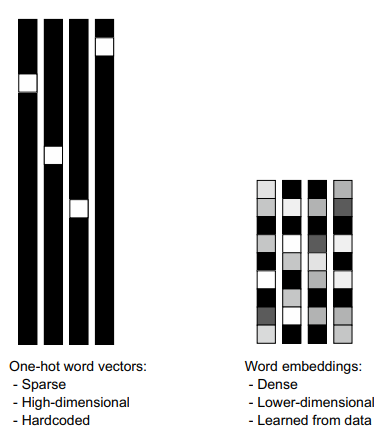

Besides being *dense* representations, word embeddings are also *structured* representations, and their structure is learned from data. Similar words get embedded in close
locations, and further, specific *directions* in the embedding space are meaningful. In real-world word-embedding spaces, common examples of meaningful geometric
transformations are “gender” vectors and “plural” vectors. For instance, by adding a
“female” vector to the vector “king,” we obtain the vector “queen.” By adding a “plural” vector, we obtain “kings.” Word-embedding spaces typically feature thousands of
such interpretable and potentially useful vectors.

Let’s look at how to use such an embedding space in practice. There are two ways
to obtain word embeddings:
- Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the
weights of a neural network.
- Load into your model word embeddings that were precomputed using a different machine learning task than the one you’re trying to solve. These are called
*pretrained word embeddings*.

Let’s review each of these approaches. 

**LEARNING WORD EMBEDDINGS WITH THE EMBEDDING LAYER**

What makes a good word-embedding space depends heavily on
your task: the perfect word-embedding space for an English-language movie-review
sentiment-analysis model may look different from the perfect embedding space for an
English-language legal-document classification model, because the importance of certain semantic relationships varies from task to task.

It’s thus reasonable to learn a new embedding space with every new task. Fortunately, backpropagation makes this easy, and Keras makes it even easier. It’s about
learning the weights of a layer: the `Embedding` layer.

### Instantiating an `Embedding` layer
The `Embedding` layer takes at least two arguments: the number of
possible tokens and the dimensionality of the embeddings (here, 256).

In [23]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

The `Embedding` layer is best understood as a dictionary that maps integer indices
(which stand for specific words) to dense vectors. It takes integers as input, looks up
these integers in an internal dictionary, and returns the associated vectors. It’s effectively a dictionary lookup.

The `Embedding` layer takes as input a rank-2 tensor of integers, of shape `(batch_size, sequence_length)`, where each entry is a sequence of integers. The layer then returns
a 3D floating-point tensor of shape `(batch_size, sequence_length, embedding_dimensionality)`.

When you instantiate an `Embedding` layer, its weights (its internal dictionary of
token vectors) are initially random, just as with any other layer. During training, these
word vectors are gradually adjusted via backpropagation, structuring the space into
something the downstream model can exploit. Once fully trained, the embedding
space will show a lot of structure—a kind of structure specialized for the specific problem for which you’re training your model.
 Let’s build a model that includes an Embedding layer and benchmark it on our task.
 
 ### Model that uses an `Embedding` layer trained from scratch


In [24]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
                loss="binary_crossentropy",
                metrics=["accuracy"])
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,
        callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

It trains much faster than the one-hot model (since the LSTM only has to process
256-dimensional vectors instead of 20,000-dimensional), and its test accuracy is comparable (87%). However, we’re still some way off from the results of our basic bigram
model. Part of the reason why is simply that the model is looking at slightly less data:
the bigram model processed full reviews, while our sequence model truncates sequences
after 600 words. 

**UNDERSTANDING PADDING AND MASKING**

One thing that’s slightly hurting model performance here is that our input sequences
are full of zeros. This comes from our use of the `output_sequence_length=max_length` option in `TextVectorization` (with `max_length` equal to 600): sentences longer than 600 tokens are truncated to a length of 600 tokens, and sentences shorter
than 600 tokens are padded with zeros at the end so that they can be concatenated
together with other sequences to form contiguous batches.

We’re using a bidirectional RNN: two RNN layers running in parallel, with one
processing the tokens in their natural order, and the other processing the same
tokens in reverse. The RNN that looks at the tokens in their natural order will spend
its last iterations seeing only vectors that encode padding—possibly for several hundreds of iterations if the original sentence was short. The information stored in the
internal state of the RNN will gradually fade out as it gets exposed to these meaningless inputs.

 We need some way to tell the RNN that it should skip these iterations. There’s an
API for that: *masking*.

The `Embedding` layer is capable of generating a “mask” that corresponds to its
input data. This mask is a tensor of ones and zeros (or True/False booleans), of shape
`(batch_size, sequence_length)`, where the entry `mask[i, t]` indicates where timestep `t` of sample `i` should be skipped or not (the timestep will be skipped if `mask[i, t]`
is 0 or False, and processed otherwise).
 By default, this option isn’t active—you can turn it on by passing `mask_zero=True`
to your `Embedding` layer. You can retrieve the mask with the `compute_mask()` method:

In [25]:
embedding_layer = layers.Embedding(input_dim=10, output_dim=256, mask_zero=True)
some_input = [
[4, 3, 2, 1, 0, 0, 0],
[5, 4, 3, 2, 1, 0, 0],
[2, 1, 0, 0, 0, 0, 0]]
mask = embedding_layer.compute_mask(some_input)
mask

<tf.Tensor: shape=(3, 7), dtype=bool, numpy=
array([[ True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True, False, False],
       [ True,  True, False, False, False, False, False]])>

In practice, you will almost never have to manage masks by hand. Instead, Keras will
automatically pass on the mask to every layer that is able to process it (as a piece of
metadata attached to the sequence it represents). This mask will be used by RNN layers to skip masked steps. If your model returns an entire sequence, the mask will also
be used by the loss function to skip masked steps in the output sequence.
 Let’s try retraining our model with masking enabled.
 
### Using an `Embedding` layer with masking enabled

In [26]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
             loss="binary_crossentropy",
             metrics=["accuracy"])
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                     save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,
          callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

This time we get to 88% test accuracy—a small but noticeable improvement. 

**USING PRETRAINED WORD EMBEDDINGS**

Sometimes you have so little training data available that you can’t use your data alone
to learn an appropriate task-specific embedding of your vocabulary. In such cases,
instead of learning word embeddings jointly with the problem you want to solve, you
can load embedding vectors from a precomputed embedding space that you know is
highly structured and exhibits useful properties—one that captures generic aspects of
language structure. The rationale behind using pretrained word embeddings in natural language processing is much the same as for using pretrained convnets in image
classification: you don’t have enough data available to learn truly powerful features on
your own, but you expect that the features you need are fairly generic—that is, common visual features or semantic features. In this case, it makes sense to reuse features
learned on a different problem.

Such word embeddings are generally computed using *word-occurrence statistics*
(observations about what words co-occur in sentences or documents), using a variety of
techniques, some involving neural networks, others not. The idea of a dense, lowdimensional embedding space for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s (see Yoshua Bengio et al., Neural Probabilistic Language Models (Springer, 2003)),
 but it only started to take off in
research and industry applications after the release of one of the most famous and successful word-embedding schemes: the Word2vec algorithm (https://code.google.com/archive/p/word2vec), developed by Tomas Mikolov at Google in 2013. Word2vec
dimensions capture specific semantic properties, such as gender.

There are various precomputed databases of word embeddings that you can download and use in a Keras `Embedding` layer. Word2vec is one of them. Another popular
one is called Global Vectors for Word Representation (GloVe, https://nlp.stanford
.edu/projects/glove), which was developed by Stanford researchers in 2014. This
embedding technique is based on factorizing a matrix of word co-occurrence statistics. Its developers have made available precomputed embeddings for millions of
English tokens, obtained from Wikipedia data and Common Crawl data.

Let’s look at how you can get started using GloVe embeddings in a Keras model.
The same method is valid for Word2Vec embeddings or any other word-embedding
database. We’ll start by downloading the GloVe files and parse them. We’ll then load
the word vectors into a Keras Embedding layer, which we’ll use to build a new model.

First, let’s download the GloVe word embeddings precomputed on the 2014
English Wikipedia dataset. It’s an 822 MB zip file containing 100-dimensional embedding vectors for 400,000 words (or non-word tokens).

In [28]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-08-10 07:41:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-08-10 07:41:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-08-10 07:41:49--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Let’s parse the unzipped file (a .txt file) to build an index that maps words (as strings)
to their vector representation.

### Parsing the GloVe word-embeddings file

In [29]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Next, let’s build an embedding matrix that you can load into an `Embedding` layer. It
must be a matrix of shape `(max_words, embedding_dim)`, where each entry *i* contains
the `embedding_dim`-dimensional vector for the word of index *i* in the reference word
index (built during tokenization).

### Preparing the GloVe word-embeddings matrix

In [30]:
embedding_dim = 100

# Retrieve the vocabulary indexed by our previous TextVectorization layer.
vocabulary = text_vectorization.get_vocabulary()
# Use it to create a mapping from words to their index in the vocabulary.
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    # Fill entry i in the matrix with the word vector for index i. 
    # Words not found in the embedding index will be all zeros.
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector 

Finally, we use a `Constant` initializer to load the pretrained embeddings in an Embedding
layer. So as not to disrupt the pretrained representations during training, we freeze
the layer via `trainable=False`:

In [31]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
    trainable=False,
    mask_zero=True,
)

We’re now ready to train a new model—identical to our previous model, but leveraging the 100-dimensional pretrained GloVe embeddings instead of 128-dimensional
learned embeddings.
### Model that uses a pretrained Embedding layer

In [32]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
             loss="binary_crossentropy",
             metrics=["accuracy"])
model.summary()
callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,
         callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
____________________________________________

You’ll find that on this particular task, pretrained embeddings aren’t very helpful,
because the dataset contains enough samples that it is possible to learn a specialized
enough embedding space from scratch. However, leveraging pretrained embeddings
can be very helpful when you’re working with a smaller dataset. 